# Example on Similarity Learning

In this notebook, a Siamese neural network is trained on the FashionMNIST dataset with a contrastive loss. Original research paper https://proceedings.neurips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf (no need to read the paper to do this assignment, this is just a - very old for the field ! - reference). There are 9 questions. Are you stuck ? Need help ? Contact martin.bauw@mines-paristech.fr

**Question 1** Briefly define a Siamese neural network (check lecture slides, short answer 2-3 sentences).

**Answer 1** A Siamese NN is a network that works with pairs of images: it computes simultaneously the outputs for a pair of images (in particular, it uses the same weights for each image of the pair). The closer these outputs are, the more similar the images are supposed to be. The distance between these two outputs helps training the network.

**Question 2** What is the specificity of the contrastive loss ? What issue does this loss help us avoid ? (check lecture slides, short answer 2-3 sentences).

**Answer 2** The contrastive loss prevents the model from predicting a constant as output. With a naive approach, this answer could actually work.

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras import backend as K

# for output representations - "embeddings" - visualization
import matplotlib.pyplot as plt, numpy as np
plt.gray() # set the colormap to “gray”
from sklearn.decomposition import PCA
from scipy import stats

# for the k nearest neighbours classification of output representations
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

<Figure size 432x288 with 0 Axes>

In [ ]:
# Load the Dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
# Prepare Train and Test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize Images
train_images = train_images / 255.0
test_images = test_images / 255.0

**Question 3** Complete the function create_pairs(). Read its description.

In [ ]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    Returns a data numpy array of size (# pairs, 2, 28, 28), and labels numpy array of size (# pairs)

    x:             the images
    digit_indices: an array, where the component n°d is an array containing all the indexes of digits n°d
    '''
    pairs = []
    labels = []
    
    # smaller number of digits
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
          # here we take care of digit d and the pair n°i
          # we create a positive pair that has not already been made
          # (we can't create all the possible positive pairs as we do not have enough ram....)
          pairs.append([x[digit_indices[d][i]],
                        x[digit_indices[d][i+1]] ] )
          labels.append(1)

          # we create a negative pair that has not already been made

          dbis = d
          while dbis == d:
            dbis = np.random.randint(10)
            
          pairs.append([x[digit_indices[d][i]],
                        x[digit_indices[dbis][i]] ] )
          labels.append(0)

    return (np.array(pairs), np.array(labels))

def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [ ]:
# Create Pairs on Train and Test sets
train_pairs, train_y = create_pairs_on_set(train_images, train_labels)
test_pairs, test_y = create_pairs_on_set(test_images, test_labels)

In [ ]:
def visualise_image(this_pair):
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,1)
  plt.imshow(test_pairs[this_pair][0])
  plt.grid(False)
  plt.subplot(1,2,2)
  plt.imshow(test_pairs[this_pair][1])
  plt.grid(False)
  plt.title('Similar? '+str(bool(test_y[this_pair])))
  plt.show()

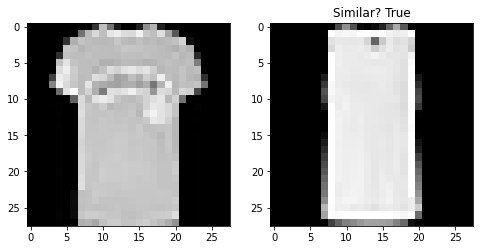

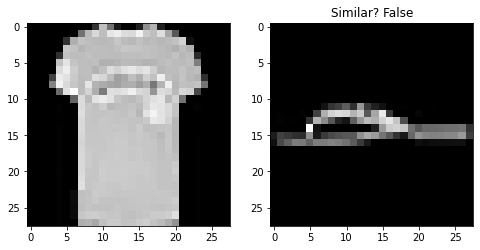

In [ ]:
visualise_image(0)
visualise_image(1)

**Question 4** Complete the function euclidean_distance().

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return tf.norm(x - y, axis = -1)

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

## Network for embedding

**Question 5** Complete the function create_base_network(): the network needs 3 dense layers with a proper activation function, a common size, and an adapted dropout should be used between dense layers 1-2, and dense layers 2-3. The final dense layer needs to output an *embedding_size* vector.

In [ ]:
def create_base_network(image_input_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).
    """
    input_image = Input(shape=image_input_shape)

    x = Flatten()(input_image)
    x = Dense(units = 512, activation="ReLU")(x)
    x = Dropout(rate = 0.1)(x)
    x = Dense(units = 512, activation="ReLU")(x)
    x = Dropout(rate = 0.1)(x)
    x = Dense(units = embedding_size, activation="softmax")(x)

    base_network = Model(inputs=input_image, outputs=x)
    base_network.summary()
    return base_network

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 3078

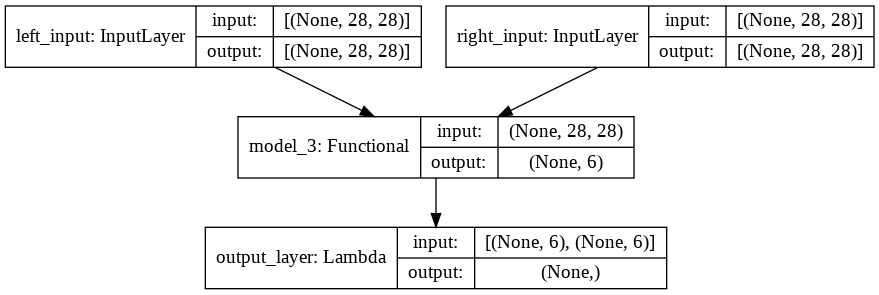

In [ ]:
embedding_size=6
input_image_shape= (28,28,)
base_network = create_base_network(input_image_shape,embedding_size)


# Left Input
input_a = Input(shape=input_image_shape, name="left_input")
vect_output_a = base_network(input_a)

# Right Input
input_b = Input(shape=input_image_shape, name="right_input")
vect_output_b = base_network(input_b)

# Calculating the similarity 
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

# Plot the Model Graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

## Definition of a Contrastive loss with margin

**Question 6** Combine y_true with square_pred and margin_square to create a contrastive_loss. y_true will appear twice.

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        
        loss = y_true * square_pred + (1 - y_true) * margin_square
        return loss
    return contrastive_loss

In [ ]:
rms = Adam()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

**Question 7** Choose an appropriate number of epochs and an adequate batch size for this training.

In [ ]:
nbr_epochs = 10
batch_size = 50

history = model.fit([train_pairs[:,0], train_pairs[:,1]], 
                    train_y, epochs=nbr_epochs, batch_size=batch_size, 
                    validation_data=([test_pairs[:,0], test_pairs[:,1]], test_y))

Epoch 1/10
2400/2400 [==============================] - 14s 5ms/step - loss: 0.1008 - val_loss: 0.0855
Epoch 2/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0800 - val_loss: 0.0773
Epoch 3/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0737 - val_loss: 0.0804
Epoch 4/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0700 - val_loss: 0.0716
Epoch 5/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0672 - val_loss: 0.0691
Epoch 6/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0651 - val_loss: 0.0695
Epoch 7/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0635 - val_loss: 0.0698
Epoch 8/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0622 - val_loss: 0.0688
Epoch 9/10
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0606 - val_loss: 0.0753
Epoch 10/10
2400/2400 [==============================] - 13s 5ms/step - l

Text(0.5, 1.0, 'Training loss')

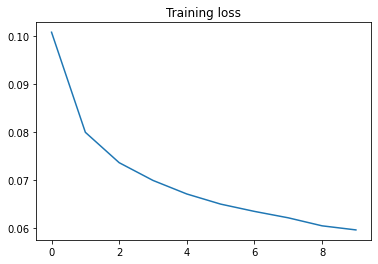

In [ ]:
plt.plot(history.history['loss'])
plt.title('Training loss')

**Question 8** Recreate the previously defined neural network without training it in a variable *testing_embeddings* and get the embeddings of the test set using this untrained version of the model in a variable *x_embeddings_before_train*. Do not delete the trained version in the process.

In [ ]:
# Test the network

'''
base_network = create_base_network(input_image_shape,embedding_size)


# Left Input
input_a = Input(shape=input_image_shape, name="left_input")
vect_output_a = base_network(input_a)

# Right Input
input_b = Input(shape=input_image_shape, name="right_input")
vect_output_b = base_network(input_b)

# Calculating the similarity 
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

testing_embeddings = Model([input_a, input_b], output)
testing_embeddings.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

plot_model(testing_embeddings, show_shapes=True, show_layer_names=True, to_file='outer-testing_embeddings.png')

x_embeddings_before_train = testing_embeddings.evaluate([test_pairs[:,0], test_pairs[:,1]], test_y)
'''

testing_embeddings = create_base_network(input_image_shape,embedding_size)
x_embeddings_before_train = testing_embeddings.predict(test_images)

# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
  weights = layer_source.get_weights()
  layer_target.set_weights(weights)
  del weights

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 3078

**Question 9** Fit a PCA on the test samples embeddings after training, and then on the test samples embeddings without training (variable *x_embeddings_before_train*), to visually check in 2D the relevance of the neural network training.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


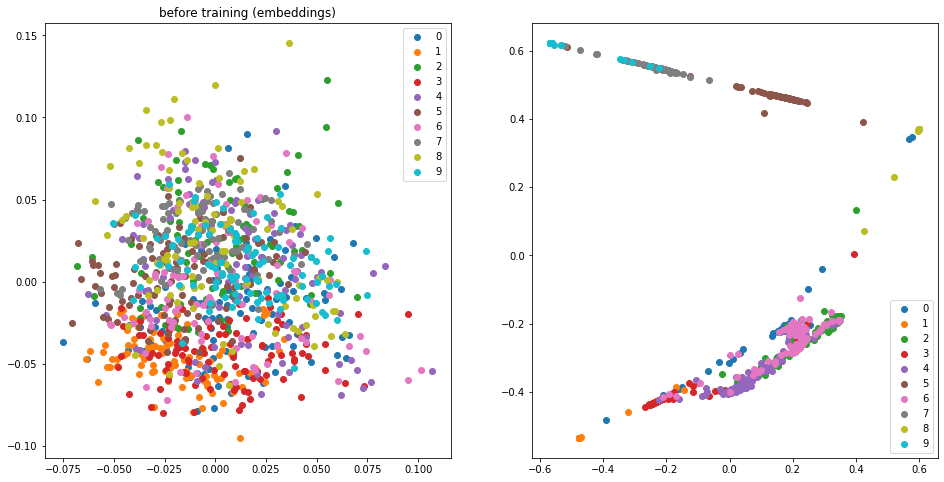

In [ ]:
# Visualizing the distribution of embeddings --> using PCA for dimensionality reduction !
no_of_components=2 # we want 2D projections
step=10 # to jump samples and avoid saturated graph https://stackoverflow.com/questions/3453085/what-is-double-colon-in-python-when-subscripting-sequences

x_embeddings = testing_embeddings.predict(test_images)
test_class_labels = np.unique(test_labels)

PCA_trained = PCA()
PCAreduced_embeddings = PCA_trained.fit_transform(x_embeddings)

PCA_untrained = PCA()
PCAreduced_untrained_embeddings = PCA_untrained.fit_transform(x_embeddings_before_train)
    
fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    PCAreduced_embeddings_class = PCAreduced_embeddings[test_labels == label]
    PCAreduced_untrained_embeddings_class = PCAreduced_untrained_embeddings[test_labels == label]

    plt.subplot(1,2,1)
    plt.scatter(PCAreduced_untrained_embeddings_class[::step,1], PCAreduced_untrained_embeddings_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(PCAreduced_embeddings_class[::step, 1], PCAreduced_embeddings_class[::step, 0], label=str(label))
    plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier 

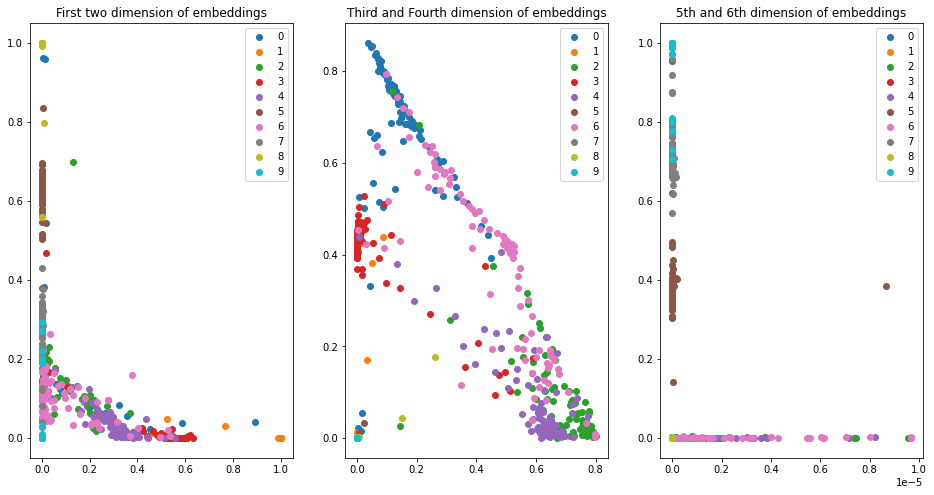

In [ ]:
# visualize embeddings dimensions 2 by 2 to avoid dimensionality reduction
# there is no such thing as too much data visualization !

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    decomposed_embeddings_class = x_embeddings[test_labels == label]


    plt.subplot(1,3,1)
    plt.scatter(decomposed_embeddings_class[::step,1], decomposed_embeddings_class[::step,0],label=str(label))
    plt.title('First two dimension of embeddings')
    plt.legend()

    plt.subplot(1,3,2)
    plt.scatter(decomposed_embeddings_class[::step, 2], decomposed_embeddings_class[::step, 3], label=str(label))
    plt.title('Third and Fourth dimension of embeddings')
    plt.legend()

    plt.subplot(1,3,3)
    plt.scatter(decomposed_embeddings_class[::step, 4], decomposed_embeddings_class[::step, 5], label=str(label))
    plt.title('5th and 6th dimension of embeddings')
    plt.legend()
plt.show()


In [ ]:
# Fit a NearestNeighbors to check whether the embeddings are relevant enough to enable
# nearest neighbor classification in the representation space generated by the trained neural network
nbrs = NearestNeighbors(n_neighbors=25).fit(x_embeddings)
distances, indices = nbrs.kneighbors(x_embeddings)

In [ ]:
class_idx=(test_labels[indices])*1.

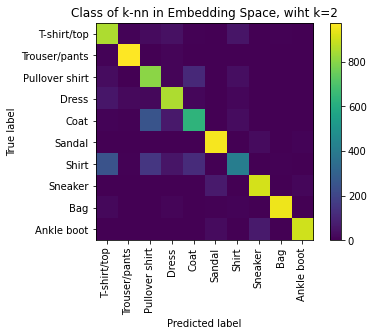

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      1000
         1.0       0.97      0.97      0.97      1000
         2.0       0.68      0.67      0.68      1000
         3.0       0.82      0.84      0.83      1000
         4.0       0.69      0.69      0.69      1000
         5.0       0.94      0.94      0.94      1000
         6.0       0.56      0.56      0.56      1000
         7.0       0.91      0.91      0.91      1000
         8.0       0.96      0.96      0.96      1000
         9.0       0.93      0.93      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
# Display a confusion matrix.
labels = [
    "T-shirt/top",
    "Trouser/pants",
    "Pullover shirt",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


k=2
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(class_idx[:,0],stats.mode(class_idx[:,1:(k+1)],axis=1)[0]), display_labels=labels)
disp.plot(include_values=False, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.title('Class of k-nn in Embedding Space, wiht k='+str(k))
plt.show()
print(classification_report(class_idx[:,0],class_idx[:,k]))

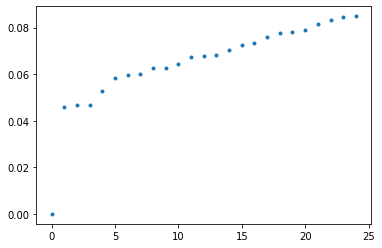

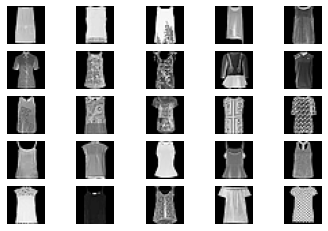

In [ ]:
# Show example evolution of best neighbors in trained representation space
idx=42
plt.figure()
plt.plot(distances[idx][0:],'.')
plt.figure()
for i in range(indices.shape[1]):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[indices[idx,i]])
    plt.axis('off')
    plt.ylabel('Distance to')
    plt.xlabel('K-neighbor in the embedding')

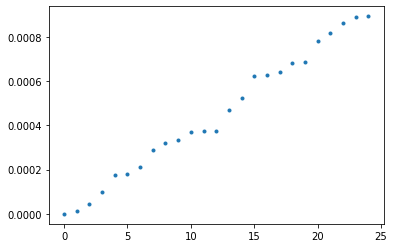

<Figure size 432x288 with 0 Axes>

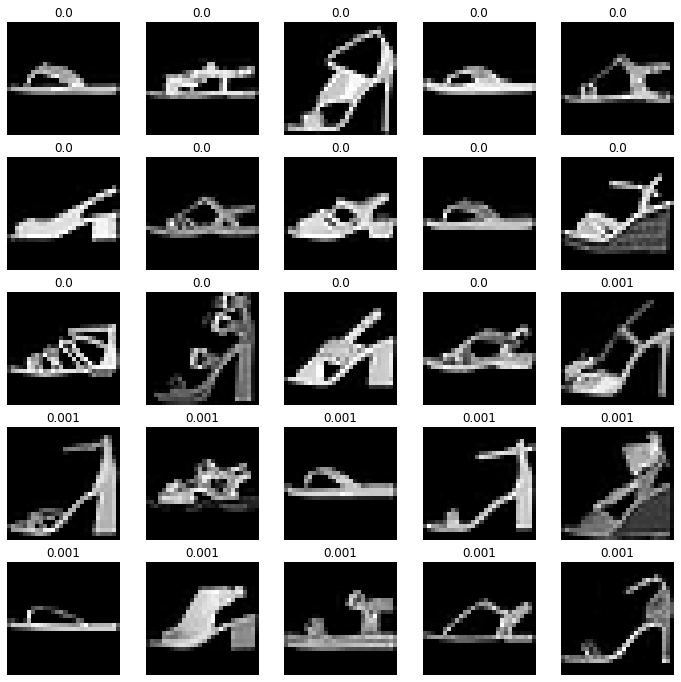

In [ ]:
# Show example evolution of best neighbors in trained representation space
idx=567
plt.figure()
plt.plot(distances[idx][0:],'.')
plt.figure()
plt.figure(figsize=(12,12))
for i in range(indices.shape[1]):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[indices[idx,i]])
    plt.title(np.round(distances[idx][i],3))
    plt.axis('off')
    plt.ylabel('Distance to')
    plt.xlabel('K-neighbor in the embedding')